In [1]:
using OrdinaryDiffEq, Flux, DiffEqFlux, Kinetic, Optim, Plots, Revise

In [2]:
case = "homogeneous"
maxTime = 3
tlen = 16
u0 = -5
u1 = 5
nu = 80
nug = 0
v0 = -5
v1 = 5
nv = 28
nvg = 0
w0 = -5
w1 = 5
nw = 28
nwg = 0
vMeshType = "rectangle"
nm = 5
knudsen = 1
inK = 0
alpha = 1.0
omega = 0.5
nh = 8;

In [3]:
tspan = (0.0, maxTime)
tran = range(tspan[1], tspan[2], length=tlen)

γ = heat_capacity_ratio(inK, 3)
vSpace = VSpace3D(u0, u1, nu, v0, v1, nv, w0, w1, nw, vMeshType)

f0 = Float32.(0.5 * (1/π)^1.5 .* (exp.(-(vSpace.u .- 0.99).^2) .+ exp.(-(vSpace.u .+ 0.99).^2)) .* 
     exp.(-vSpace.v.^2) .* exp.(-vSpace.w.^2)) |> Array
prim0 = conserve_prim(moments_conserve(f0, vSpace.u, vSpace.v, vSpace.w, vSpace.weights), γ)
M0 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim0)) |> Array

mu_ref = ref_vhs_vis(knudsen, alpha, omega)
kn_bzm = hs_boltz_kn(mu_ref, 1.0)
τ0 = mu_ref * 2. * prim0[end]^(0.5) / prim0[1];

In [4]:
phi, psi, phipsi = kernel_mode( nm, vSpace.u1, vSpace.v1, vSpace.w1, vSpace.du[1,1,1], vSpace.dv[1,1,1], vSpace.dw[1,1,1],
                                vSpace.nu, vSpace.nv, vSpace.nw, alpha );

In [5]:
function boltzmann!(df, f::Array{<:Real,3}, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [6]:
#--- Boltzmann ---#
prob = ODEProblem(boltzmann!, f0, tspan, [kn_bzm, nm, phi, psi, phipsi])
data_boltz = solve(prob, Tsit5(), saveat=tran) |> Array;

#--- BGK ---#
prob1 = ODEProblem(bgk!, f0, tspan, [M0, τ0])
data_bgk = solve(prob1, Tsit5(), saveat=tran) |> Array;

In [7]:
data_boltz_1D = zeros(Float32, axes(data_boltz, 1), axes(data_boltz, 4))
data_bgk_1D = zeros(Float32, axes(data_bgk, 1), axes(data_bgk, 4))
for j in axes(data_boltz_1D, 2), i in axes(data_boltz_1D, 1)
    data_boltz_1D[i,j] = sum(@. vSpace.weights[i,:,:] * data_boltz[i,:,:,j])
    data_bgk_1D[i,j] = sum(@. vSpace.weights[i,:,:] * data_bgk[i,:,:,j])
end

f0_1D = zeros(Float32, axes(f0, 1))
for i in axes(data_boltz_1D, 1)
    f0_1D[i] = sum(@. vSpace.weights[i,:,:] * f0[i,:,:])
end

M0_1D = zeros(Float32, axes(M0, 1))
for i in axes(M0, 1)
    M0_1D[i] = sum(@. vSpace.weights[i,:,:] * M0[i,:,:])
end

In [8]:
X = Array{Float32}(undef, vSpace.nu, 1)
for i in axes(X, 2)
    X[:, i] .= f0_1D
end

Y = Array{Float32}(undef, vSpace.nu, 1, tlen)
for i in axes(Y, 2)
    Y[:, i, :] .= data_boltz_1D
end

M = Array{Float32}(undef, nu, size(X, 2))
for i in axes(M, 2)
    M[:, i] .= M0_1D
end

τ = Array{Float32}(undef, 1, size(X, 2))
for i in axes(τ, 2)
    τ[1, i] = τ0
end

In [19]:
model_univ = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(nu, nu * nh, tanh),
    #FastDense(nu * nh, nu * nh, tanh),
    FastDense(nu * nh, nu),
)

p_model = initial_params(model_univ)

function dfdt(f, p, t)
    df = (M .- f) ./ τ .+ model_univ(M .- f, p)
end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    #sol_ube = solve(prob_ube, RK4(), u0=X, p=p, saveat=tran)
    sol_ube = solve(prob_ube, Euler(), u0=X, p=p, dt=maxTime / (tlen-1))
    loss = sum(abs2, Array(sol_ube) .- Y)

    return loss
end

his = []
cb = function(p, l)
    #display(l)
    push!(his, l)
    return false
end

#5 (generic function with 1 method)

In [20]:
res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=cb, maxiters=200)

loss: 1.07e-07: 100%|███████████████████████████████████| Time: 0:00:31


 * Status: success

 * Candidate solution
    Final objective value:     1.072356e-07

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   42  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


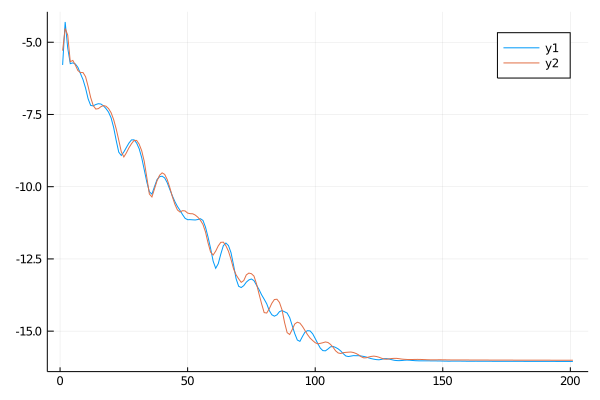

In [22]:
plot(log.(his))
plot!(log.(his1))

### Compare training perfermances from different optimizers

In [199]:
his = []
res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=cb, maxiters=156)
his_adam = his;

his = []
res = DiffEqFlux.sciml_train(loss, p_model, Nesterov(), cb=cb, maxiters=156)
his_nes = his;

his = []
res = DiffEqFlux.sciml_train(loss, p_model, LBFGS(), cb=cb, maxiters=600) # BFGS is special
his_bfgs = his;

his = []
res = DiffEqFlux.sciml_train(loss, p_model, Momentum(), cb=cb, maxiters=156)
his_mom = his;

his = []
res = DiffEqFlux.sciml_train(loss, p_model, RMSProp(), cb=cb, maxiters=156)
his_rms = his;

his = []
res = DiffEqFlux.sciml_train(loss, p_model, NADAM(), cb=cb, maxiters=156)
his_nad = his;

loss: 2.25e-07: 100%|█████████████████████████████████████████| Time: 0:00:05


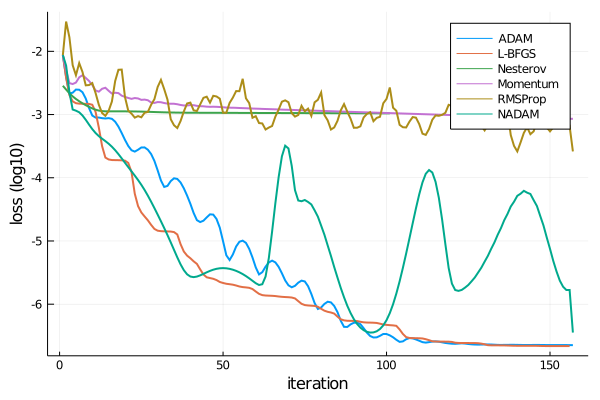

In [296]:
ploss=plot(log10.(his_adam), lw=2, label="ADAM", xlabel="iteration", ylabel="loss (log10)")
ploss=plot!(log10.(his_bfgs), lw=2, label="L-BFGS")
ploss=plot!(log10.(his_nest), lw=2, label="Nesterov")
ploss=plot!(log10.(his_mom), lw=2, label="Momentum")
ploss=plot!(log10.(his_rms), lw=2, label="RMSProp")
ploss=plot!(log10.(his_nad), lw=2, label="NADAM", color=89)

In [297]:
savefig(ploss, "loss.pdf")

### Calculate solution from trained UBE

In [359]:
function ube_rhs(f, p, t)
    M = p[1:nu]
    τ = p[nu+1]
    p_nn = p[nu+2:end]

    (M .- f) ./ τ .+ model_univ(M .- f, p_nn)
end

ube_rhs (generic function with 1 method)

In [360]:
ube = ODEProblem(ube_rhs, f0_1D, tspan, [M0_1D; τ0; res.minimizer]);
sol = solve(ube, Midpoint(), u0=f0_1D, p=[M0_1D; τ0; res.minimizer], saveat=tran);

In [361]:
tran

0.0:0.2:3.0

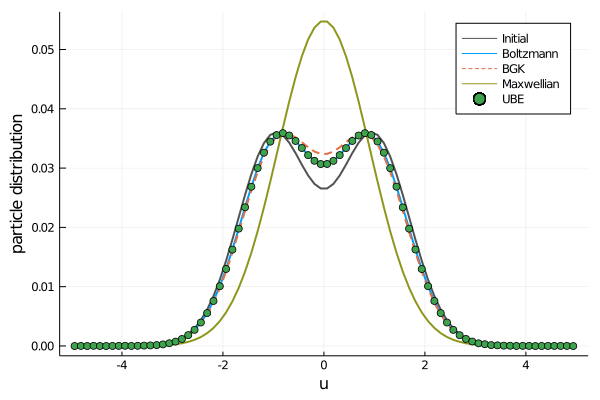

In [375]:
t1=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
t1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,2], lw=2, label="Boltzmann", color=1)
t1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_bgk_1D[:,2], lw=2, line=:dash, label="BGK", color=2)
t1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
t1=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol.u[2], lw=2, label="UBE", color=3)

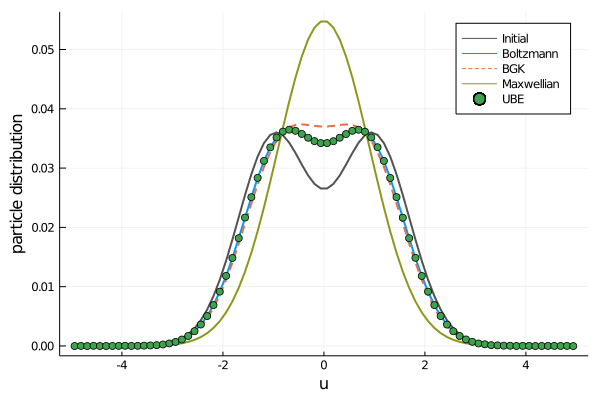

In [376]:
t2=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
t2=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,3], lw=2, label="Boltzmann", color=1)
t2=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_bgk_1D[:,3], lw=2, line=:dash, label="BGK", color=2)
t2=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
t2=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol.u[3], lw=2, label="UBE", color=3)

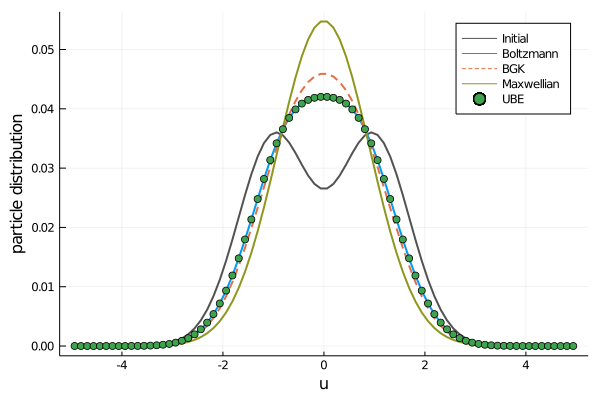

In [377]:
t3=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
t3=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,6], lw=2, label="Boltzmann", color=1)
t3=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_bgk_1D[:,6], lw=2, line=:dash, label="BGK", color=2)
t3=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
t3=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol.u[6], lw=2, label="UBE", color=3)

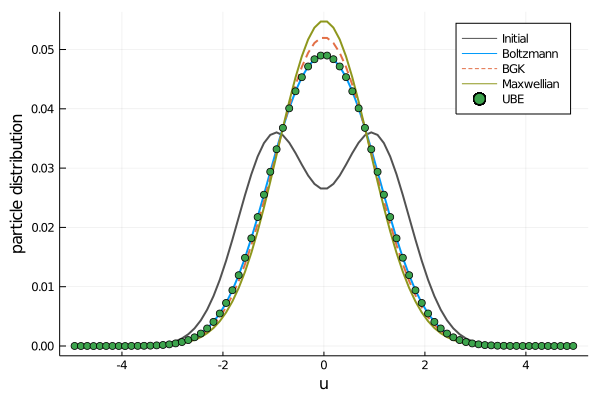

In [378]:
t4=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,11], lw=2, label="Boltzmann", color=1)
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_bgk_1D[:,11], lw=2, line=:dash, label="BGK", color=2)
t4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
t4=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol.u[11], lw=2, label="UBE", color=3)

In [380]:
savefig(t1, "train_t0.2.pdf")
savefig(t2, "train_t0.4.pdf")
savefig(t3, "train_t1.0.pdf")
savefig(t4, "train_t2.0.pdf")

### Interpolation

In [368]:
ube_inter = ODEProblem(ube_rhs, f0_1D, tspan.*0.5, [M0_1D; τ0; res.minimizer],);
sol_inter = solve(ube_inter, Midpoint(), u0=f0_1D, p=[M0_1D; τ0; res.minimizer], saveat=tran.*0.5);

be_inter = ODEProblem(boltzmann!, f0, tspan.*0.5, [kn_bzm, nm, phi, psi, phipsi])
data_boltz_inter = solve(be_inter, Midpoint(), saveat=tran.*0.5) |> Array;

data_boltz_1D_inter = zeros(Float32, axes(data_boltz_inter, 1), axes(data_boltz_inter, 4))
for j in axes(data_boltz_1D_inter, 2), i in axes(data_boltz_1D_inter, 1)
    data_boltz_1D_inter[i,j] = sum(@. vSpace.weights[i,:,:] * data_boltz_inter[i,:,:,j])
end

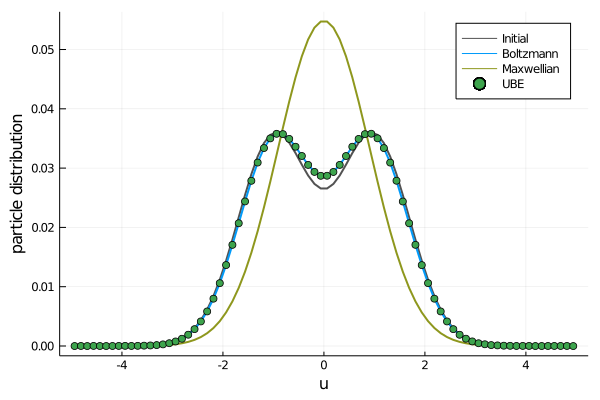

In [381]:
i1=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_inter[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
i1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_inter[:,2], lw=2, label="Boltzmann", color=1)
i1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
i1=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol_inter.u[2], lw=2, label="UBE", color=3)

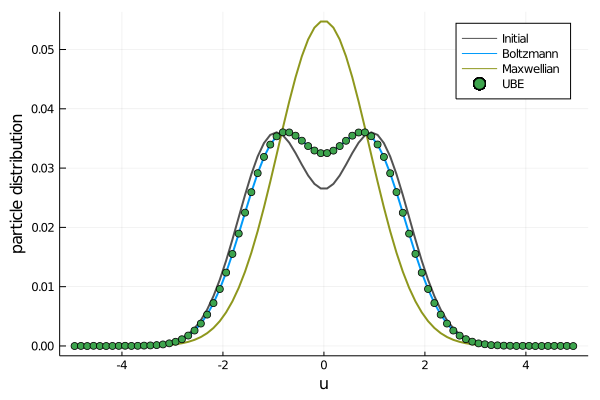

In [382]:
i2=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_inter[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
i2=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_inter[:,4], lw=2, label="Boltzmann", color=1)
i2=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
i2=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol_inter.u[4], lw=2, label="UBE", color=3)

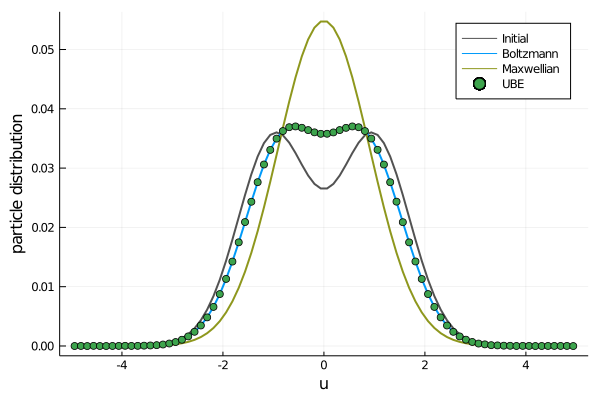

In [383]:
i3=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_inter[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
i3=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_inter[:,6], lw=2, label="Boltzmann", color=1)
i3=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
i3=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol_inter.u[6], lw=2, label="UBE", color=3)

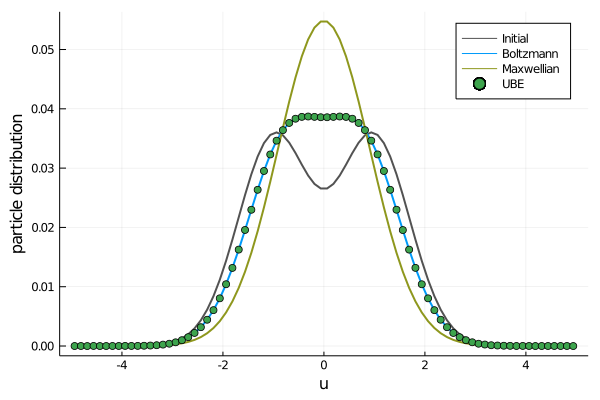

In [384]:
i4=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_inter[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
i4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_inter[:,8], lw=2, label="Boltzmann", color=1)
i4=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
i4=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol_inter.u[8], lw=2, label="UBE", color=3)

In [385]:
savefig(i1, "inter_t0.1.pdf")
savefig(i2, "inter_t0.3.pdf")
savefig(i3, "inter_t0.5.pdf")
savefig(i4, "inter_t0.7.pdf")

### Extrapolation

In [341]:
ube_extra = ODEProblem(ube_rhs, f0_1D, tspan.*3, [M0_1D; τ0; res.minimizer],);
sol_extra = solve(ube_extra, Midpoint(), u0=f0_1D, p=[M0_1D; τ0; res.minimizer], saveat=tran.*3);

be_extra = ODEProblem(boltzmann!, f0, tspan.*3, [kn_bzm, nm, phi, psi, phipsi])
data_boltz_extra = solve(be_extra, Midpoint(), saveat=tran.*3) |> Array;

data_boltz_1D_extra = zeros(Float32, axes(data_boltz_extra, 1), axes(data_boltz_extra, 4))
for j in axes(data_boltz_1D_extra, 2), i in axes(data_boltz_1D_extra, 1)
    data_boltz_1D_extra[i,j] = sum(@. vSpace.weights[i,:,:] * data_boltz_extra[i,:,:,j])
end

In [410]:
bgk_extra_1D = ODEProblem(bgk!, f0_1D, tspan.*3, [M0_1D, τ0])
data_bgk_1D_extra = solve(bgk_extra_1D, Midpoint(), saveat=tran.*3) |> Array;

In [388]:
tran.*3  |> Vector

16-element Array{Float64,1}:
 0.0
 0.6
 1.2
 1.7999999999999998
 2.4
 3.0
 3.5999999999999996
 4.2
 4.8
 5.3999999999999995
 6.0
 6.6
 7.199999999999999
 7.8
 8.4
 9.0

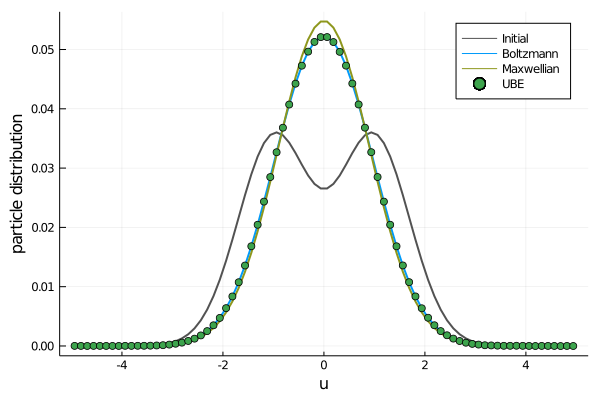

In [389]:
e1=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
e1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_extra[:,11], lw=2, label="Boltzmann", color=1)
e1=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D, lw=2, label="Maxwellian", color=10)
e1=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol_extra.u[11], lw=2, label="UBE", color=3)

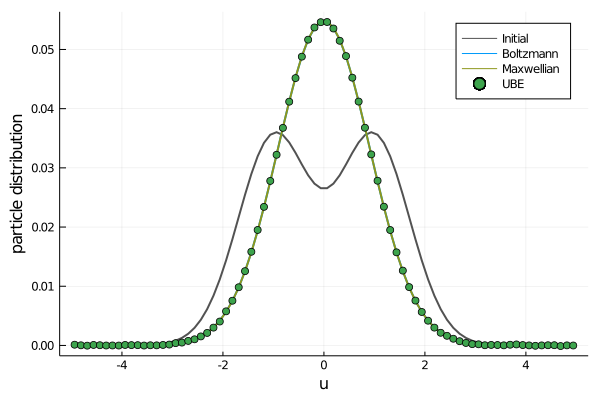

In [390]:
e2=plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial", color=:gray32, xlabel="u", ylabel="particle distribution")
e2=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D_extra[:,end], lw=2, label="Boltzmann", color=1)
e2=plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], M0_1D[:,end], lw=2, label="Maxwellian", color=10)
e2=scatter!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], sol_extra.u[end], lw=2, label="UBE", color=3)

In [391]:
savefig(e1, "extra_t6.0.pdf")
savefig(e2, "extra_t9.0.pdf")

In [394]:
fevolve = zeros(tlen, nu)
for i in axes(fevolve, 1)
    fevolve[i,:] .= sol_extra.u[i]
end

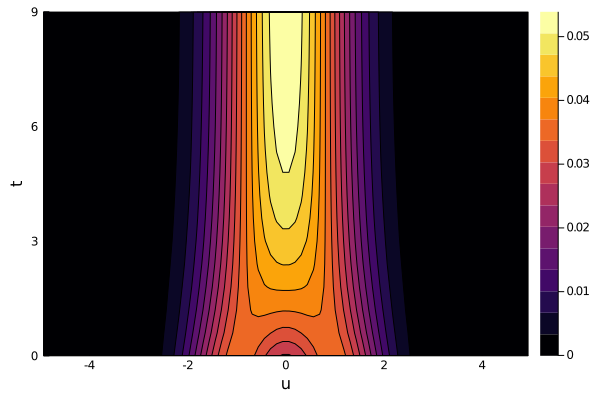

In [405]:
econtour=contourf(vSpace.u[:,1,1], tran.*3, fevolve, xlabel="u", ylabel="t")

In [406]:
savefig(econtour, "extra_contour.pdf")

In [416]:
nnpart = zeros(tlen, nu)
for i in axes(nnpart, 1)
    nnpart[i,:] .= (M0_1D .- fevolve[i,:]) ./ τ0 .+ model_univ(M0_1D .- fevolve[i,:], res.minimizer)
end

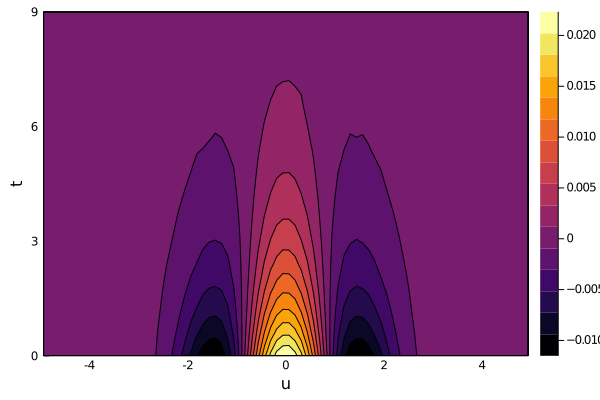

In [418]:
ederi = contourf(vSpace.u[:,1,1], tran.*3, nnpart, xlabel="u", ylabel="t")

In [419]:
savefig(ederi, "extra_derivative.pdf")

### Efficiency

In [400]:
using BenchmarkTools

In [402]:
@benchmark sol_extra = solve(ube_extra, Tsit5(), u0=f0_1D, p=[M0_1D; τ0; res.minimizer], saveat=tran.*3)

BenchmarkTools.Trial: 
  memory estimate:  242.25 MiB
  allocs estimate:  5638
  --------------
  minimum time:     89.296 ms (60.79% GC)
  median time:      142.429 ms (43.90% GC)
  mean time:        144.862 ms (43.37% GC)
  maximum time:     221.963 ms (32.40% GC)
  --------------
  samples:          35
  evals/sample:     1

In [403]:
@benchmark solve(be_extra, Tsit5(), saveat=tran.*3)

BenchmarkTools.Trial: 
  memory estimate:  7.42 GiB
  allocs estimate:  194610
  --------------
  minimum time:     4.707 s (21.86% GC)
  median time:      4.825 s (24.23% GC)
  mean time:        4.825 s (24.23% GC)
  maximum time:     4.944 s (26.48% GC)
  --------------
  samples:          2
  evals/sample:     1

In [408]:
bench_be = @benchmarkable solve(be_extra, Tsit5(), saveat=tran.*3)
tune!(bench_be);

In [409]:
run(bench_be) # seems tuning doesn't increase samples

BenchmarkTools.Trial: 
  memory estimate:  7.42 GiB
  allocs estimate:  194610
  --------------
  minimum time:     4.587 s (21.57% GC)
  median time:      4.784 s (24.20% GC)
  mean time:        4.784 s (24.20% GC)
  maximum time:     4.982 s (26.63% GC)
  --------------
  samples:          2
  evals/sample:     1